In [20]:
import numpy as np
from scipy.fftpack import fft, ifft
from scipy.stats import skew, kurtosis, moment

def loychikSD_NP(x, Fs, Fbe):
    # Frequency bin centers
    F = Fbe[:-1] + np.diff(Fbe)
    t = np.arange(0, len(x)) / Fs
    dF = 1 / t[-1]
    Ff = np.arange(0, len(x)) * dF  # FFT frequency step

    M = np.array([
        np.mean(x),
        np.var(x),
        skew(x),
        kurtosis(x),
        moment(x, 1),
        moment(x, 2),
        moment(x, 3),
    ])

    # Initialize arrays for storing results
    Gx = np.zeros(len(F))
    Sx = np.zeros(len(F))
    Kx = np.zeros(len(F))
    M3x = np.zeros(len(F))
    M4x = np.zeros(len(F))

    X = fft(x)

    for ii in range(len(F)):
        print(f"{ii+1} out of {len(F)}")  # Counter to determine where you are in the run

        # Find the index where FFT frequency is greater than or equal to Fbe[ii+1]
        Xn = np.where(Ff >= Fbe[ii + 1])[0][0]

        # Low-pass filter by zeroing bins
        cutX = X[1:Xn+1]  # Adjusted here
        XI = np.zeros(X.shape, dtype=complex)
        XI[1:Xn+1] = cutX  # Adjusted here

        # Make code more similar to Python by replacing symmetric tag with complex conjugate
        XI[1:Xn] = np.conj(cutX[:-1][::-1])  # Adjusted here, assuming we keep the symmetry

        xifft = ifft(XI)

        magnitude = np.abs(xifft)
        Gx[ii] = np.var(magnitude)
        Sx[ii] = skew(magnitude)
        Kx[ii] = kurtosis(magnitude)
        M3x[ii] = moment(magnitude, 3)
        M4x[ii] = moment(magnitude, 4)
        
    return M, F, Gx, Sx, Kx


In [21]:
from scipy.signal import butter, filtfilt
from scipy.signal import hann, welch
import numpy as np

Fs = 2000
Tr = 1000  # Primary variable
dF = 1 / Tr

t = np.arange(0, Tr, 1 / Fs)
x = np.random.randn(len(t))

# Interpolation for anti-aliasing
x = np.interp(np.linspace(0, len(x), len(x) * 6), np.arange(len(x)), x)
Fs = 6 * Fs
N = Fs
t = np.arange(0, Tr, 1 / Fs)

x2 = -np.random.lognormal(0, 1, len(x))
x2 = x2 - np.mean(x2)

# Butterworth filtering
b, a = butter(6, 20 / (Fs / 2), btype='high')
x = filtfilt(b, a, x)
x2 = filtfilt(b, a, x2)
b, a = butter(6, 2000 / (Fs / 2))
x = filtfilt(b, a, x)
x2 = filtfilt(b, a, x2)

x3a = x
b, a = butter(6, 20 / (Fs / 2), btype='high')
x3a = filtfilt(b, a, x3a)
b, a = butter(6, 200 / (Fs / 2))
x3a = filtfilt(b, a, x3a)

x3b = x2
b, a = butter(6, 180 / (Fs / 2), btype='high')
x3b = filtfilt(b, a, x3b)
b, a = butter(6, 2000 / (Fs / 2))
x3b = filtfilt(b, a, x3b)

x3a = x3a * 1.05
x3b = x3b * 1.2
x3 = x3a + x3b

f, GxxW1 = welch(x3a, Fs, window=hann(N), nperseg=N)
f, GxxW2 = welch(x3b, Fs, window=hann(N), nperseg=N)
f, GxxW3 = welch(x3, Fs, window=hann(N), nperseg=N)

GxxW = np.column_stack([GxxW1, GxxW2, GxxW3])

from scipy.stats import gaussian_kde
import numpy as np
import matplotlib.pyplot as plt

xclip1 = x[:Fs*10 + 1]
xclip2 = x2[:Fs*10 + 1]
xclip3 = x3[:Fs*10 + 1]

tclip = np.arange(len(xclip1)) / Fs

# Kernel Density Estimation
ks_density_x = gaussian_kde(x)
ks_density_x2 = gaussian_kde(x2)

faaa = np.linspace(min(x), max(x), 1000)
xaaa = ks_density_x.evaluate(faaa)

faaa2 = np.linspace(min(x2), max(x2), 1000)
xaaa2 = ks_density_x2.evaluate(faaa2)

# If you want to plot, uncomment these lines
# plt.figure()
# plt.subplot(2, 1, 1)
# plt.plot(faaa, xaaa)
# plt.title("KDE for x")

# plt.subplot(2, 1, 2)
# plt.plot(faaa2, xaaa2)
# plt.title("KDE for x2")

# plt.show()

import numpy as np
import scipy.io
import scipy.signal
import scipy.ndimage

# The octspace function is not directly available in Python's standard libraries, you may have to implement it
# Fbe = octspace(10, 6000, 12).center  # Your octave space function
Fbe = np.logspace(np.log10(10), np.log10(6000), 12)  # Placeholder using logspace
Fbe = Fbe  # Assuming Fbe.center in MATLAB just returns Fbe

M, F, Gx, Sx, Kx = loychikSD_NP(x3, Fs, Fbe)

# Power Spectral Density
Gxx = np.gradient(Gx, F)

# Skewness Spectral Density
Sxx = np.gradient(Sx, F)

# Kurtosis Spectral Density
Kxx = np.gradient(Kx, F)

# Fourth Central Moment Spectral Density
# M4xx = np.gradient(Kx * Gx ** 2, F)

# Clear variables
del x, x2, x3

# Save variables
scipy.io.savemat("KSDMixedSignal100-1.mat", {"M": M, "F": F, "Gx": Gx, "Sx": Sx, "Kx": Kx})

print("MAT file saved. Mission accomplished.")




1 out of 11
2 out of 11
3 out of 11
4 out of 11
5 out of 11
6 out of 11
7 out of 11
8 out of 11
9 out of 11
10 out of 11
11 out of 11
MAT file saved. Mission accomplished.


{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Wed Oct 18 12:29:19 2023', '__version__': '1.0', '__globals__': [], 'M': array([[ 6.36157526e-06,  1.92713366e+00, -1.87558770e+00,
         1.45757014e+01,  0.00000000e+00,  1.92713366e+00,
        -5.01770508e+00]]), 'F': array([[  17.88789367,   31.99767398,   57.23709898,  102.38511403,
         183.14540328,  327.60854995,  586.02269058, 1048.27115753,
        1875.13629997, 3354.22387443, 6000.        ]]), 'Gx': array([[1.12673018e-06, 1.01230047e-03, 4.05531075e-03, 9.35982795e-03,
        1.81423669e-02, 3.63390532e-02, 8.05380082e-02, 1.77019201e-01,
        3.53477172e-01, 3.65102125e-01, 3.65102137e-01]]), 'Sx': array([[86.21869433,  0.63365102,  0.64462867,  0.63266539,  0.6248697 ,
         0.82170463,  1.55042082,  2.52799696,  3.57414873,  3.71396126,
         3.71396103]]), 'Kx': array([[9.41296367e+03, 3.06451627e-01, 2.78061738e-01, 2.47696832e-01,
        2.25365527e-01, 1.14245418e+00, 6.75231612e+00,

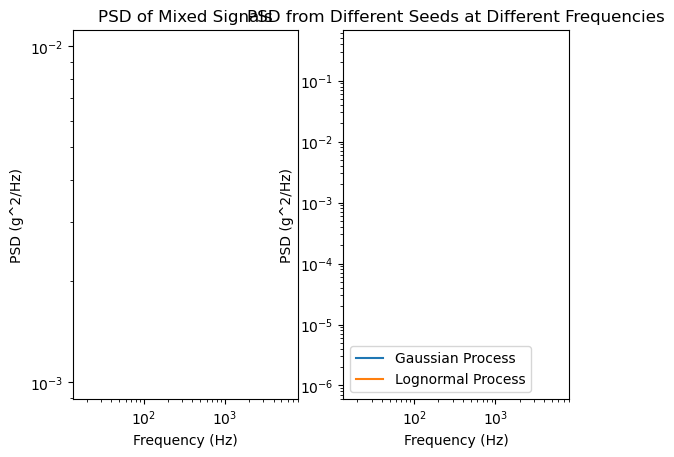

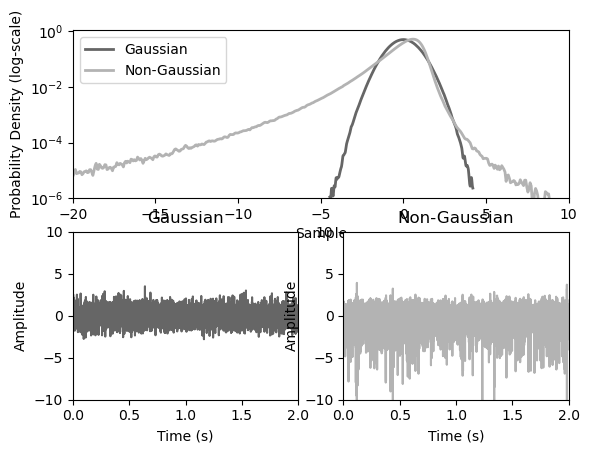

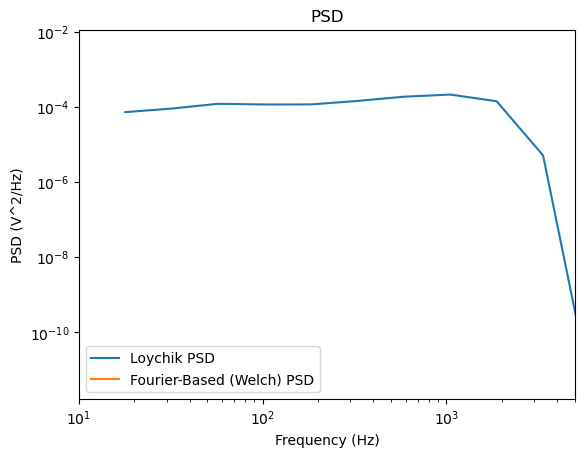

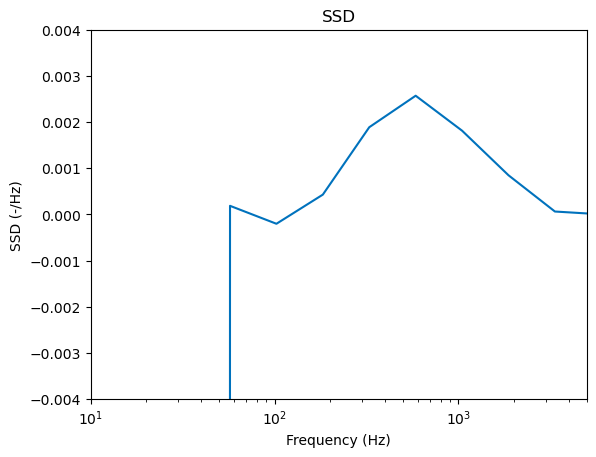

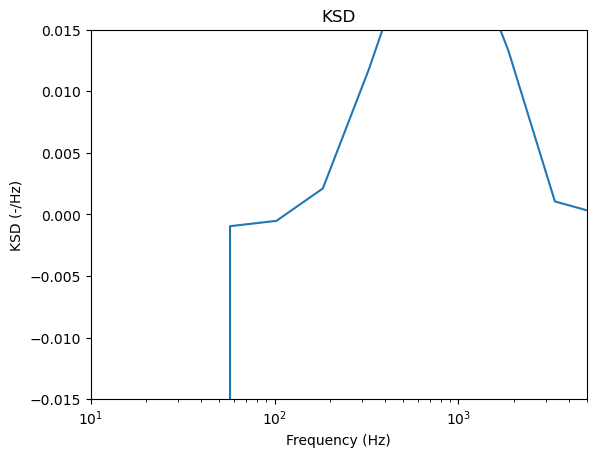

In [27]:
# Graphs

import matplotlib.pyplot as plt
import scipy.io
import numpy as np

# Load MAT file
data = scipy.io.loadmat("KSDMixedSignal100-1.mat")
print(data)
GxxW = data['Gx']
f = data['F']

# Figure 1
plt.figure(1)

plt.subplot(1, 2, 1)
plt.loglog(f, GxxW[:, 2], linewidth=1.5)
plt.ylabel('PSD (g^2/Hz)')
plt.xlabel('Frequency (Hz)')
plt.title('PSD of Mixed Signals')

plt.subplot(1, 2, 2)
plt.loglog(f, GxxW[:], linewidth=1.5)
plt.ylabel('PSD (g^2/Hz)')
plt.xlabel('Frequency (Hz)')
plt.title('PSD from Different Seeds at Different Frequencies')
plt.legend(['Gaussian Process', 'Lognormal Process'], loc='lower left')

# Figure 2
plt.figure(2)
plt.clf()

plt.subplot(2, 2, (1, 2))
plt.semilogy(faaa, xaaa, linewidth=2, color=[.4, .4, .4])
plt.semilogy(faaa2, xaaa2, linewidth=2, color=[.7, .7, .7])
plt.xlim([-20, 10])
plt.ylim([.000001, 1.1])
plt.ylabel('Probability Density (log-scale)')
plt.xlabel('Sample')
plt.legend(['Gaussian', 'Non-Gaussian'])

# 
# Figure 2 (continued)
plt.subplot(2, 2, 3)
plt.plot(tclip, xclip1, color=[.4, .4, .4])
plt.xlim([0, 2])
plt.ylim([-10, 10])
plt.title('Gaussian')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.subplot(2, 2, 4)
plt.plot(tclip, xclip2, color=[.7, .7, .7])
plt.xlim([0, 2])
plt.ylim([-10, 10])
plt.title('Non-Gaussian')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Figure 3
plt.figure(3)
plt.loglog(F, Gxx, f, GxxW[:, 2], linewidth=1.5)
plt.legend(['Loychik PSD', 'Fourier-Based (Welch) PSD'], loc='lower left')
plt.title('PSD')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (V^2/Hz)')
plt.xlim([10, 5000])

# Figure 4
plt.figure(4)
plt.semilogx(F, Sxx, linewidth=1.5, color=[0, 0.4470, 0.7410])
plt.title('SSD')
plt.xlabel('Frequency (Hz)')
plt.ylabel('SSD (-/Hz)')
plt.xlim([10, 5000])
plt.ylim([-.004, .004])

# Figure 5
plt.figure(5)
plt.semilogx(F, Kxx, linewidth=1.5)
plt.title('KSD')
plt.xlabel('Frequency (Hz)')
plt.ylabel('KSD (-/Hz)')
plt.xlim([10, 5000])
plt.ylim([-.015, .015])

plt.show()


## Audio input

In [64]:
from scipy.signal import butter, filtfilt
from scipy.signal import hann, welch
import numpy as np

from scipy.io import wavfile

# Read audio file
#filefolder = wavfile.read("/Users/karthikkurella/Downloads/good-sounds/sound_files/violin_raquel_pitch_stability/neumann/0000.wav")

Fs, audio_data = wavfile.read("/Users/karthikkurella/Downloads/good-sounds/sound_files/violin_raquel_pitch_stability/neumann/0000.wav")

# Use the audio_data as your x3 or whichever variable you want to replace
x3 = audio_data.astype(float)


M, F, Gx, Sx, Kx = loychikSD_NP(x3, Fs, Fbe)

# Power Spectral Density
Gxx = np.gradient(Gx, F)

# Skewness Spectral Density
Sxx1 = np.gradient(Sx, F)

# Kurtosis Spectral Density
Kxx1 = np.gradient(Kx, F)

# Fourth Central Moment Spectral Density
# M4xx = np.gradient(Kx * Gx ** 2, F)

# Clear variables
# del x, x2, x3

# Save variables
scipy.io.savemat("Audio-1.mat", {"M": M, "F": F, "Gx": Gx, "Sx": Sx, "Kx": Kx})

print("MAT file saved. Mission accomplished.")




/var/folders/g8/ryts82jd3c33vl83y_np4dzm0000gn/T/ipykernel_80362/588606318.py:10: WavFileWarning: Chunk (non-data) not understood, skipping it.
  Fs, audio_data = wavfile.read("/Users/karthikkurella/Downloads/good-sounds/sound_files/violin_raquel_pitch_stability/neumann/0000.wav")


1 out of 11
2 out of 11
3 out of 11
4 out of 11
5 out of 11
6 out of 11
7 out of 11
8 out of 11
9 out of 11
10 out of 11
11 out of 11
MAT file saved. Mission accomplished.


{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Wed Oct 18 14:20:42 2023', '__version__': '1.0', '__globals__': [], 'M': array([[-2.41135606e+03,  6.42956816e+16,  1.20314201e-01,
         1.32936055e+00,  0.00000000e+00,  6.42956816e+16,
         1.96150581e+24]]), 'F': array([[  17.88789367,   31.99767398,   57.23709898,  102.38511403,
         183.14540328,  327.60854995,  586.02269058, 1048.27115753,
        1875.13629997, 3354.22387443, 6000.        ]]), 'Gx': array([[2.27018533e+11, 2.43133054e+11, 1.17382306e+13, 3.18445311e+13,
        9.81798386e+15, 1.06020012e+16, 1.13374908e+16, 1.16783335e+16,
        1.16970653e+16, 1.16971854e+16, 1.16971947e+16]]), 'Sx': array([[ 0.50815468,  0.51585229, -0.02847941,  1.33408195,  0.2592891 ,
         0.38204163,  0.52001927,  0.5799757 ,  0.58438286,  0.58439429,
         0.58439654]]), 'Kx': array([[-0.41065289, -0.27515796, -0.60391657,  2.65978503, -0.72847138,
        -0.48407686, -0.12895216,  0.03346859,  0.0511

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

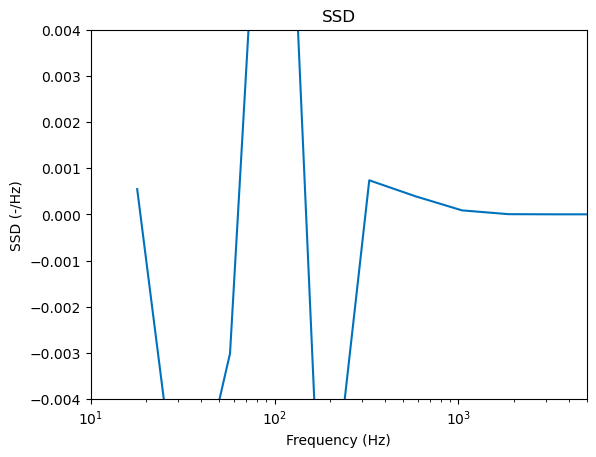

In [41]:
# Graphs

import matplotlib.pyplot as plt
import scipy.io
import numpy as np

# Load MAT file
data = scipy.io.loadmat("Audio-1.mat")
print(data)
GxxW = data['Gx']
f = data['F']

# Figure 1
plt.figure(1)

# plt.subplot(1, 2, 1)
# plt.loglog(f, GxxW[:, 2], linewidth=1.5)
# plt.ylabel('PSD (g^2/Hz)')
# plt.xlabel('Frequency (Hz)')
# plt.title('PSD of Mixed Signals')

# plt.subplot(1, 2, 2)
# plt.loglog(f, GxxW[:], linewidth=1.5)
# plt.ylabel('PSD (g^2/Hz)')
# plt.xlabel('Frequency (Hz)')
# plt.title('PSD from Different Seeds at Different Frequencies')
# plt.legend(['Gaussian Process', 'Lognormal Process'], loc='lower left')

# Figure 2
plt.figure(2)
plt.clf()

# plt.subplot(2, 2, (1, 2))
# plt.semilogy(faaa, xaaa, linewidth=2, color=[.4, .4, .4])
# plt.semilogy(faaa2, xaaa2, linewidth=2, color=[.7, .7, .7])
# plt.xlim([-20, 10])
# plt.ylim([.000001, 1.1])
# plt.ylabel('Probability Density (log-scale)')
# plt.xlabel('Sample')
# plt.legend(['Gaussian', 'Non-Gaussian'])

# 
# Figure 2 (continued)
# plt.subplot(2, 2, 3)
# plt.plot(tclip, xclip1, color=[.4, .4, .4])
# plt.xlim([0, 2])
# plt.ylim([-10, 10])
# plt.title('Gaussian')
# plt.xlabel('Time (s)')
# plt.ylabel('Amplitude')

# plt.subplot(2, 2, 4)
# plt.plot(tclip, xclip2, color=[.7, .7, .7])
# plt.xlim([0, 2])
# plt.ylim([-10, 10])
# plt.title('Non-Gaussian')
# plt.xlabel('Time (s)')
# plt.ylabel('Amplitude')

# # Figure 3
# plt.figure(3)
# plt.loglog(F, Gxx, f, GxxW[:, 2], linewidth=1.5)
# plt.legend(['Loychik PSD', 'Fourier-Based (Welch) PSD'], loc='lower left')
# plt.title('PSD')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('PSD (V^2/Hz)')
# plt.xlim([10, 5000])

# Figure 4
plt.figure(4)
plt.semilogx(F, Sxx1, linewidth=1.5, color=[0, 0.4470, 0.7410])
plt.title('SSD')
plt.xlabel('Frequency (Hz)')
plt.ylabel('SSD (-/Hz)')
plt.xlim([10, 5000])
plt.ylim([-.004, .004])

# # Figure 5
# plt.figure(5)
# plt.semilogx(F, Kxx, linewidth=1.5)
# plt.title('KSD')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('KSD (-/Hz)')
# plt.xlim([10, 5000])
# plt.ylim([-.015, .015])

plt.show()


In [54]:
from scipy.signal import butter, filtfilt
from scipy.signal import hann, welch
import numpy as np

from scipy.io import wavfile

# Read audio file
sample_rate, audio_data = wavfile.read("/Users/karthikkurella/Downloads/good-sounds/sound_files/flute_almudena_stability/neumann/0000.wav")

# Use the audio_data as your x3 or whichever variable you want to replace
x3 = audio_data.astype(float)


M, F, Gx, Sx, Kx = loychikSD_NP(x3, Fs, Fbe)

# Power Spectral Density
Gxx = np.gradient(Gx, F)

# Skewness Spectral Density
Sxx2 = np.gradient(Sx, F)

# Kurtosis Spectral Density
Kxx2 = np.gradient(Kx, F)

# Fourth Central Moment Spectral Density
# M4xx = np.gradient(Kx * Gx ** 2, F)

# Clear variables
# del x, x2, x3

# Save variables
scipy.io.savemat("Audio-1.mat", {"M": M, "F": F, "Gx": Gx, "Sx": Sx, "Kx": Kx})

print("MAT file saved. Mission accomplished.")




/var/folders/g8/ryts82jd3c33vl83y_np4dzm0000gn/T/ipykernel_80362/3817508641.py:8: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, audio_data = wavfile.read("/Users/karthikkurella/Downloads/good-sounds/sound_files/flute_almudena_stability/neumann/0000.wav")


1 out of 11
2 out of 11
3 out of 11
4 out of 11
5 out of 11
6 out of 11
7 out of 11
8 out of 11
9 out of 11
10 out of 11
11 out of 11
MAT file saved. Mission accomplished.


In [55]:
from scipy.signal import butter, filtfilt
from scipy.signal import hann, welch
import numpy as np

from scipy.io import wavfile

# Read audio file
sample_rate, audio_data = wavfile.read("/Users/karthikkurella/Downloads/good-sounds/sound_files/trumpet_ramon_pitch_stability/neumann/0000.wav")

# Use the audio_data as your x3 or whichever variable you want to replace
x3 = audio_data.astype(float)


M, F, Gx, Sx, Kx = loychikSD_NP(x3, Fs, Fbe)

# Power Spectral Density
Gxx = np.gradient(Gx, F)

# Skewness Spectral Density
Sxx3 = np.gradient(Sx, F)

# Kurtosis Spectral Density
Kxx3 = np.gradient(Kx, F)

# Fourth Central Moment Spectral Density
# M4xx = np.gradient(Kx * Gx ** 2, F)

# Clear variables
# del x, x2, x3

# Save variables
scipy.io.savemat("Audio-1.mat", {"M": M, "F": F, "Gx": Gx, "Sx": Sx, "Kx": Kx})

print("MAT file saved. Mission accomplished.")




1 out of 11
2 out of 11
3 out of 11
4 out of 11
5 out of 11
6 out of 11
7 out of 11
8 out of 11
9 out of 11
10 out of 11
11 out of 11
MAT file saved. Mission accomplished.


/var/folders/g8/ryts82jd3c33vl83y_np4dzm0000gn/T/ipykernel_80362/3940632841.py:8: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, audio_data = wavfile.read("/Users/karthikkurella/Downloads/good-sounds/sound_files/trumpet_ramon_pitch_stability/neumann/0000.wav")


{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Wed Oct 18 14:33:11 2023', '__version__': '1.0', '__globals__': [], 'M': array([[1.77901051e+02, 8.35852263e+16, 1.38592226e+00, 2.15791264e+00,
        0.00000000e+00, 8.35852263e+16, 3.34913885e+25]]), 'F': array([[  17.88789367,   31.99767398,   57.23709898,  102.38511403,
         183.14540328,  327.60854995,  586.02269058, 1048.27115753,
        1875.13629997, 3354.22387443, 6000.        ]]), 'Gx': array([[1.30042824e+09, 1.41431577e+09, 1.49429335e+09, 7.26500453e+09,
        6.09002964e+10, 7.66291764e+15, 1.37136401e+16, 1.70091135e+16,
        1.71797182e+16, 1.71804524e+16, 1.71804755e+16]]), 'Sx': array([[ 0.76805749,  0.80186314,  0.86485489,  1.97178004,  1.80016562,
        -0.54023123,  0.25184744,  0.83717225,  0.91375914,  0.91438303,
         0.91438805]]), 'Kx': array([[ 0.31893796,  0.45066312,  0.90672926,  6.85065791,  4.57167805,
        -0.96410334, -0.90618774,  0.43057139,  0.81875325,  0.823886

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

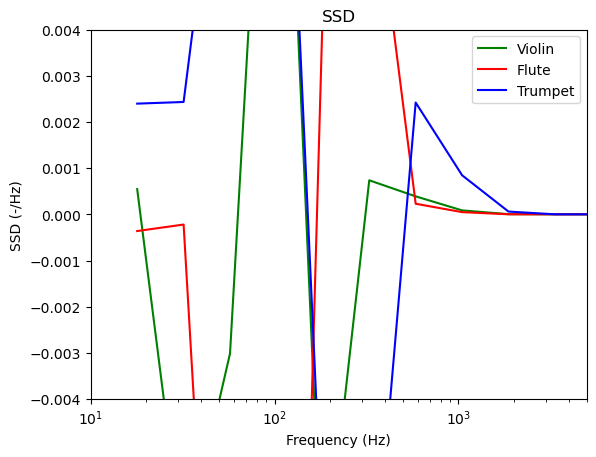

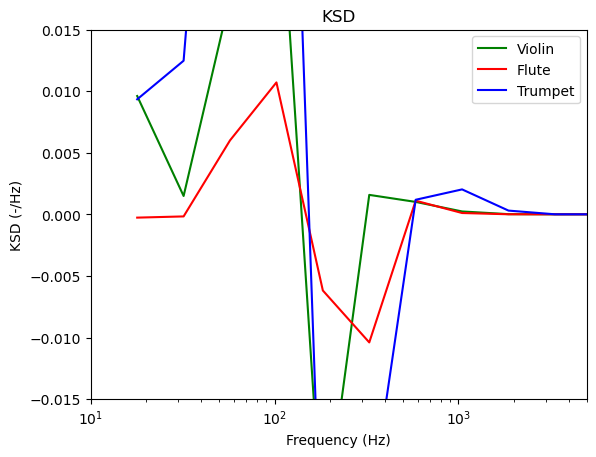

In [56]:
# Graphs

import matplotlib.pyplot as plt
import scipy.io
import numpy as np

# Load MAT file
data = scipy.io.loadmat("Audio-1.mat")
print(data)
GxxW = data['Gx']
f = data['F']

# Figure 1
plt.figure(1)

# plt.subplot(1, 2, 1)
# plt.loglog(f, GxxW[:, 2], linewidth=1.5)
# plt.ylabel('PSD (g^2/Hz)')
# plt.xlabel('Frequency (Hz)')
# plt.title('PSD of Mixed Signals')

# plt.subplot(1, 2, 2)
# plt.loglog(f, GxxW[:], linewidth=1.5)
# plt.ylabel('PSD (g^2/Hz)')
# plt.xlabel('Frequency (Hz)')
# plt.title('PSD from Different Seeds at Different Frequencies')
# plt.legend(['Gaussian Process', 'Lognormal Process'], loc='lower left')

# Figure 2
plt.figure(2)
plt.clf()

# plt.subplot(2, 2, (1, 2))
# plt.semilogy(faaa, xaaa, linewidth=2, color=[.4, .4, .4])
# plt.semilogy(faaa2, xaaa2, linewidth=2, color=[.7, .7, .7])
# plt.xlim([-20, 10])
# plt.ylim([.000001, 1.1])
# plt.ylabel('Probability Density (log-scale)')
# plt.xlabel('Sample')
# plt.legend(['Gaussian', 'Non-Gaussian'])

# 
# Figure 2 (continued)
# plt.subplot(2, 2, 3)
# plt.plot(tclip, xclip1, color=[.4, .4, .4])
# plt.xlim([0, 2])
# plt.ylim([-10, 10])
# plt.title('Gaussian')
# plt.xlabel('Time (s)')
# plt.ylabel('Amplitude')

# plt.subplot(2, 2, 4)
# plt.plot(tclip, xclip2, color=[.7, .7, .7])
# plt.xlim([0, 2])
# plt.ylim([-10, 10])
# plt.title('Non-Gaussian')
# plt.xlabel('Time (s)')
# plt.ylabel('Amplitude')

# # Figure 3
# plt.figure(3)
# plt.loglog(F, Gxx, f, GxxW[:, 2], linewidth=1.5)
# plt.legend(['Loychik PSD', 'Fourier-Based (Welch) PSD'], loc='lower left')
# plt.title('PSD')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('PSD (V^2/Hz)')
# plt.xlim([10, 5000])

# Figure 4
plt.figure(4)
plt.semilogx(F, Sxx1, linewidth=1.5,  color='green',label="Violin")
plt.semilogx(F, Sxx2, linewidth=1.5, color='red',label = "Flute")
plt.semilogx(F, Sxx3, linewidth=1.5, color='blue',label = "Trumpet")

#plt.semilogx(F, Sxx3, linewidth=1.5, color='blue')
plt.title('SSD')
plt.xlabel('Frequency (Hz)')
plt.ylabel('SSD (-/Hz)')
plt.xlim([10, 5000])
plt.ylim([-.004, .004])
plt.legend(labels=["Violin", "Flute","Trumpet"])

# # Figure 5
plt.figure(5)
plt.semilogx(F, Kxx1, linewidth=1.5,color='green',label="Violin")
plt.semilogx(F, Kxx2, linewidth=1.5,color='red',label="Flute")
plt.semilogx(F, Kxx3, linewidth=1.5,color='blue',label="Trumpet")

plt.title('KSD')
plt.xlabel('Frequency (Hz)')
plt.ylabel('KSD (-/Hz)')
plt.xlim([10, 5000])
plt.ylim([-.015, .015])
plt.legend(labels=["Violin", "Flute","Trumpet"])

plt.show()


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split

# Simulated waveform data for 3 different instruments (0, 1, 2)
# Each sample is a waveform with 1000 data points
n_samples = 1000
n_data_points = 1000
n_classes = 3

# Generate some example data
#X = np.random.rand(n_samples, n_data_points, 1)  # Replace with your actual waveform data
X = Sxx1
y = np.random.randint(0, n_classes, n_samples)  # Replace with your actual labels

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create 1D CNN model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(n_data_points, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {loss}, Test accuracy: {accuracy}")


In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import scipy.io

# Load the MAT file
# Assuming it's in the same directory and named 'Audio-1.mat'
data = scipy.io.loadmat('Audio-1.mat')

# Combine your spectral descriptors into a single feature vector
# This is just an example; you might want to scale or normalize the features
features = np.column_stack((data['M'], data['Gx'], data['Sx'], data['Kx']))

# Dummy labels; replace these with actual labels if you have them
labels = np.random.randint(2, size=features.shape[0])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Initialize the Random Forest model
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")



ValueError: With n_samples=1, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [58]:
print("Shapes of loaded data:")
print(f"M: {data['M'].shape}")
print(f"F: {data['F'].shape}")
print(f"Gx: {data['Gx'].shape}")
print(f"Sx: {data['Sx'].shape}")
print(f"Kx: {data['Kx'].shape}")

Shapes of loaded data:
M: (1, 7)
F: (1, 11)
Gx: (1, 11)
Sx: (1, 11)
Kx: (1, 11)
